In [ ]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)


Mounted at /content/drive/


In [ ]:
from tensorflow.keras.layers import Input,Lambda, Dense, Flatten
from tensorflow.keras.models import Model,load_model


# from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2	
from tensorflow.keras.applications.resnet_v2 import ResNet152V2

# from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [ ]:
IMAGE_SIZE = [224, 224]

train_path = 'drive/MyDrive/Colab Notebooks/Cotton Disease/train'
valid_path = 'drive/MyDrive/Colab Notebooks/Cotton Disease/val'
test_path="drive/MyDrive/Colab Notebooks/Cotton Disease/test"


In [ ]:
output_classes=glob("drive/MyDrive/Colab Notebooks/Cotton Disease/train/*")

In [ ]:
ResNet152V2 = ResNet152V2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


234561536/234545216 [==============================] - 1s 0us/step


In [ ]:
for layer in ResNet152V2.layers:
    layer.trainable = False#using the same weights as downloaded

In [ ]:
x = Flatten()(ResNet152V2.output)

In [ ]:
prediction = Dense(len(output_classes), activation='softmax')(x)

# create a model object
model = Model(inputs=ResNet152V2.input, outputs=prediction)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range=30, fill_mode='nearest',
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory('drive/MyDrive/Colab Notebooks/Cotton Disease/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
valid_set = valid_datagen.flow_from_directory('drive/MyDrive/Colab Notebooks/Cotton Disease/val',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')
test_set = test_datagen.flow_from_directory('drive/MyDrive/Colab Notebooks/Cotton Disease/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')



Found 1951 images belonging to 4 classes.
Found 253 images belonging to 4 classes.
Found 106 images belonging to 4 classes.


In [ ]:
from keras.callbacks import ModelCheckpoint

model_path = '/content/drive/My Drive/ResnetV2.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
model.compile(
  loss='categorical_crossentropy',
  optimizer="Adam",
  metrics=['accuracy']
)

In [ ]:
training_set.class_indices

{'diseased cotton leaf': 0,
 'diseased cotton plant': 1,
 'fresh cotton leaf': 2,
 'fresh cotton plant': 3}

In [ ]:
import tensorflow as tf
device_name=tf.test.gpu_device_name()
if device_name!='/device:GPU:0':
  raise SystemError("GPU not found")
print("device found",device_name)

device found /device:GPU:0


In [ ]:
with tf.device("/gpu:0"):

  r = model.fit_generator(
    training_set,
    validation_data=valid_set,
    epochs=20,
    steps_per_epoch=len(training_set),
    validation_steps=len(valid_set),
    callbacks=callbacks_list


  )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/20
61/61 [==============================] - ETA: 0s - loss: 1.5710 - accuracy: 0.7986
Epoch 1: val_accuracy improved from -inf to 0.90909, saving model to /content/drive/My Drive/ResnetV2.h5
61/61 [==============================] - 528s 8s/step - loss: 1.5710 - accuracy: 0.7986 - val_loss: 0.7266 - val_accuracy: 0.9091
Epoch 2/20
61/61 [==============================] - ETA: 0s - loss: 0.5877 - accuracy: 0.9180
Epoch 2: val_accuracy did not improve from 0.90909
61/61 [==============================] - 42s 690ms/step - loss: 0.5877 - accuracy: 0.9180 - val_loss: 0.7512 - val_accuracy: 0.9051
Epoch 3/20
61/61 [==============================] - ETA: 0s - loss: 0.5030 - accuracy: 0.9241
Epoch 3: val_accuracy improved from 0.90909 to 0.91700, saving model to /content/drive/My Drive/ResnetV2.h5
61/61 [==============================] - 45s 742ms/step - loss: 0.5030 - accuracy: 0.9241 - val_loss: 0.5813 - val_accuracy: 0.9170
Epoch 4/20
61/61 [==============================] - ETA: 0s 

In [ ]:
saved_model=load_model("/content/drive/MyDrive/ResnetV2.h5")

In [ ]:
_, acc = saved_model.evaluate_generator(training_set, steps=len(training_set), verbose=0)
print('> %.3f' % (acc * 100.0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


> 97.899


In [ ]:
_, acc = saved_model.evaluate_generator(valid_set, steps=len(valid_set), verbose=0)
print('> %.3f' % (acc * 100.0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


> 96.443


In [ ]:

with tf.device("/gpu:0"):
  _, acc = saved_model.evaluate_generator(test_set, steps=len(test_set), verbose=0)
  print('> %.3f' % (acc * 100.0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


> 98.113


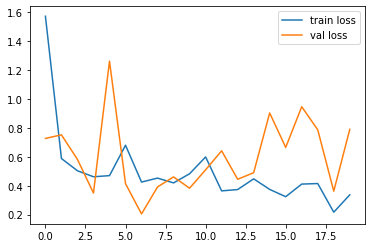

In [ ]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()

plt.savefig('LossVal_loss')



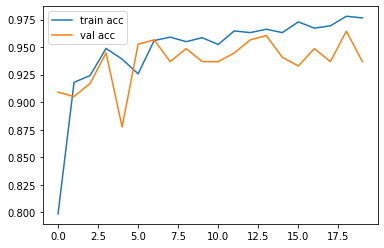

In [ ]:
# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('AccVal_acc')

In [ ]:
from tensorflow.keras.models import load_model

saved_model.save('ResnetV2.h5')

In [ ]:
y_pred = saved_model.predict(test_set)

In [ ]:
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
training_set.class_indices

{'diseased cotton leaf': 0,
 'diseased cotton plant': 1,
 'fresh cotton leaf': 2,
 'fresh cotton plant': 3}

In [ ]:
import cv2
import tensorflow as tf

In [ ]:
from keras.preprocessing.image import img_to_array

def pred_cot_dieas(cott_plant):
  test_image = load_img(cott_plant,target_size=(224,224,3)) # load image 

  plt.imshow(test_image)
  test_image = img_to_array(test_image)/255 # convert image to np array and normalize
  test_image = np.expand_dims(test_image, axis = 0) # change dimention 3D to 4D
   
  result = saved_model.predict(test_image).round(3) # predict diseased plant or not

   
  pred = np.argmax(result) # get the index of max value

  if pred == 0:
    return "Diseased Cotton Leaf" # if index 0 burned leaf
  elif pred == 1:
      return 'Diseased Cotton Plant' # # if index 1
  elif pred == 2:
      return 'Healthy Cotton Leaf'  # if index 2  fresh leaf
  else:
    return "Healthy Cotton Plant" # if index 3

'Healthy Cotton Leaf'

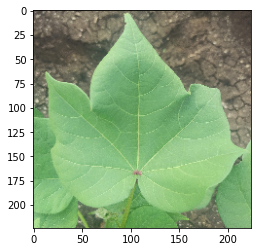

In [ ]:
pred_cot_dieas("/content/drive/MyDrive/Colab Notebooks/cotton_plant_data/test/fresh cotton leaf/d (341).jpg")